In [141]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.constraints import Interval
from gpytorch.constraints import GreaterThan
from scipy.stats import norm
import shutil


DTYPE = torch.get_default_dtype()

In [142]:
FONTSIZE = 18

# Try LaTeX settings, fall back gracefully
try:
    if shutil.which("latex") is not None:
        plt.rc("text", usetex=True)
        plt.rc(
            "text.latex",
            preamble=r"\usepackage{amsmath}\usepackage[bitstream-charter]{mathdesign}",
        )
        plt.rc("font", family="serif", size=FONTSIZE, serif="Charter")
    else:
        raise RuntimeError("LaTeX not found")
except Exception:
    # Fallback to default matplotlib serif font
    plt.rc("text", usetex=False)
    plt.rc("font", family="serif", size=FONTSIZE)

plt.rc("axes", titlesize="medium")

# Define color cycle
colors = [f"C{i}" for i in range(5)]

In [143]:
# Get some simple toy function
def generate_data(n_samples, unc=0.2, seed=None):
    """
    Simple 1D regression problem based
    """
    if seed is not None:
        np.random.seed(seed)
    # x = np.concatenate((np.random.uniform(-1, -0.22, n_samples // 2), np.random.uniform(0.22, 1, n_samples - n_samples // 2)))
    x = np.random.uniform(-2, 2, n_samples)
    theta_true = np.array([1.0, 2.0, -0.5])
    y = theta_true[0] + theta_true[1] * x + theta_true[2] * x**2
    # y = 0.5 * np.sin(23*x) + x/2
    y_noise = (
        y + np.random.randn(n_samples) * unc
    )  # * (x+1) #+ np.random.randn(n_samples) * unc/2
    return x, y_noise

In [144]:
x_np, y_np = generate_data(200, unc=0.5, seed=42)
Y_STD = y_np.std()
Y_MEAN = y_np.mean()
y_train_scaled = (y_np - Y_MEAN) / Y_STD
x_train = torch.tensor(x_np, dtype=DTYPE).unsqueeze(-1)
y_train = torch.tensor(y_train_scaled, dtype=DTYPE)

In [145]:
# === GP Model ===
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale_constraint=Interval(0.001, 10.0))
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# === Instantiate model and likelihood ===
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

In [146]:
# === Training mode ===
model.train()
likelihood.train()
training_iter = 100

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# === Training loop ===
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()
    if (i + 1) % 10 == 0:
        print(
            "Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f"
            % (
                i + 1,
                training_iter,
                loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item(),
            )
        )

Iter 10/100 - Loss: 0.492   lengthscale: 2.731   noise: 0.312
Iter 20/100 - Loss: 0.128   lengthscale: 1.868   noise: 0.125
Iter 30/100 - Loss: -0.114   lengthscale: 2.103   noise: 0.051
Iter 40/100 - Loss: -0.134   lengthscale: 2.796   noise: 0.030
Iter 50/100 - Loss: -0.138   lengthscale: 3.264   noise: 0.032
Iter 60/100 - Loss: -0.149   lengthscale: 3.163   noise: 0.040
Iter 70/100 - Loss: -0.148   lengthscale: 3.142   noise: 0.041
Iter 80/100 - Loss: -0.150   lengthscale: 3.279   noise: 0.038
Iter 90/100 - Loss: -0.150   lengthscale: 3.334   noise: 0.037
Iter 100/100 - Loss: -0.151   lengthscale: 3.350   noise: 0.038


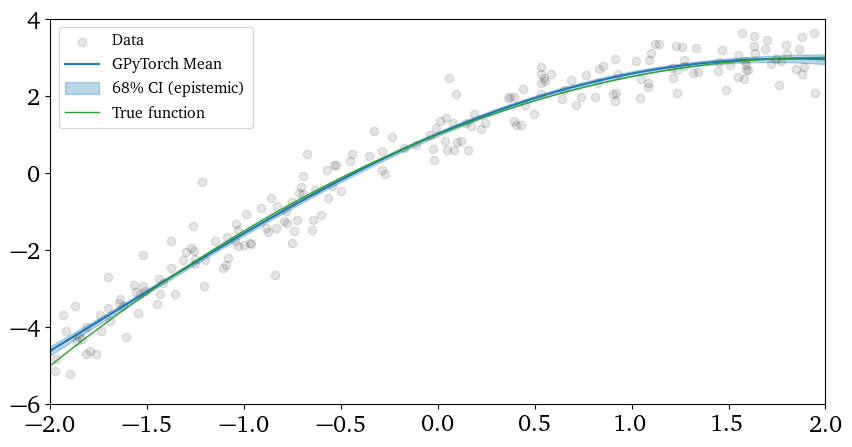

In [147]:
# === Evaluation ===
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    Xtest = torch.linspace(-2, 2, 2000).unsqueeze(-1)
    pred_raw = model(Xtest)
    pred = likelihood(pred_raw)
    mean = pred.mean * Y_STD + Y_MEAN  # Rescale mean
    std_epi = pred_raw.variance.sqrt() * Y_STD
    std_all = pred.variance.sqrt() * Y_STD
    std_alea = torch.sqrt(std_all**2 - std_epi**2)

    z = norm.ppf(0.84)  # two-sided: (1 + 0.95)/2
    lower = mean - z * std_epi
    upper = mean + z * std_epi
    lower_alea = mean - z * std_alea
    upper_alea = mean + z * std_alea
    # lower, upper = pred.confidence_region()

    # Plot
    plt.figure(figsize=(10, 5))
    plt.scatter(x_train.numpy(), y_np, alpha=1 / 10, label="Data", color="k")
    plt.plot(Xtest.numpy(), mean.numpy(), label="GPyTorch Mean")
    plt.fill_between(
        Xtest.squeeze().numpy(),
        lower.numpy(),
        upper.numpy(),
        alpha=0.3,
        label=r"68\% CI (epistemic)",
        color="C0",
        zorder=-10,
    )
    # plt.fill_between(Xtest.squeeze().numpy(), lower_alea.numpy(), upper_alea.numpy(), alpha=0.1, label=r'95\% CI (aleatoric)', color="C1", zorder=-10)
    # plt.axvspan(-0.22, 0.22, color='gray', alpha=0.2)
    # plt.axvspan(1, 1.2, color='gray', alpha=0.2)
    # plt.axvspan(-1.2, -1.0, color='gray', alpha=0.2)
    theta_true = np.array([1.0, 2.0, -0.5])
    y = theta_true[0] + theta_true[1] * Xtest + theta_true[2] * Xtest**2
    # y = 0.5 * torch.sin(23*Xtest) + Xtest/2
    plt.plot(Xtest, y, color="C2", label="True function", linewidth=1)
    plt.legend(fontsize=FONTSIZE - 6, loc="upper left")
    plt.ylim(-6, 4)
    plt.xlim(-2, 2)
    plt.show()